In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import time
import random
import worker as wr
import simulation as sm
import os
from decimal import *

# Simulation Project Demo (FA23)

The purpose of this notebook is to further modularize simulation model v1 and incorporate our own twists to examine the behavior of gender-based bias in the corporate workplace.

In [2]:
# Global Variables / References:

# Appropriate staff sizes for each level:
level_sizes = {
    1 : 800,
    2 : 175,
    3 : 50,
    4 : 15
}

# The impact that seniority has on staying time - older people retire later?
# Set negative for opposite effect.
level_ext_stay_times = {
    1 : 1,
    2 : 2,
    3 : 3,
    4 : 1.5
}

# The impact that gender has on staying time -- women pushed out quicker?
gender_stay_times = {
    0 : 4.3,
    1 : 2.15
}

# A database to store workers, organized by level:
# Implemented as simple lists, ordered from most to least senior by employee index.
worker_db = {
    1 : [],
    2 : [],
    3 : [],
    4 : []
}

### Base Hiring/Promoting/Leaving Processes

In [3]:
def base_remove_expired_workers(worker_db):
    """
    This function traverses through the database of workers, and removes
    those with end times that have been reached. It does so by iterating through
    each level of worker in the database, checking the current time vs. the
    worker's end time. If this time has passed, then we remove the worker.
    """
    for level in worker_db.keys():
        
        l = len(worker_db[level])
        idx = 0
        
#       keys are being changed during the loop- for loop won't work!
        while idx < l:
#           if a worker has 'expired', kick 'em out!
            if worker_db[level][idx].get_end_time() < time.time():
                worker_db[level] = worker_db[level][:idx] \
                                    + worker_db[level][idx+1:]
#               reflect that the size of the level is one less after removal
                l -= 1
            idx += 1
            
    
def base_check_leave(worker_db, leave_db):
    for level in worker_db.keys():
        l = len(worker_db[level])
        idx = 0
        
        while idx < l:
            if worker_db[level][idx].det_go_on_leave():
                leave_db[level].append(worker_db[level][idx])
                worker_db[level] = worker_db[level][:idx] \
                                        + worker_db[level][idx+1:]
                l -= 1
            idx += 1
     
    for level in leave_db.keys():
        l = len(leave_db[level])
        idx = 0
        
        while idx < l:
            if time.time() > leave_db[level][idx].get_leave_time():
                worker_db[level].append(leave_db[level][idx])
                worker_db[level][len(worker_db[level]) - 1].set_end_time(gender_stay_times, level_ext_stay_times)
                leave_db[level] = leave_db[level][:idx] + leave_db[level][idx+1:]
                l -= 1
            idx += 1      

def base_hire_worker(worker_db, level, idx, male_productivity=(5,2), female_productivity=(5,2),\
                     all_male=False, all_female=False):
    """
    This function hires new workers
    """
    
    assert not all_female or not all_male
    # Randomized gender for new hire -- Change to 3 evenutally for NB case?
    if all_female:
        gender = 1
    elif all_male:
        gender = 0
    else:
        gender = random.randint(0,1)

    # Create worker:
    hire = wr.Worker(level, gender, idx, time.time())
    hire.set_end_time(gender_stay_times, level_ext_stay_times)
    hire.set_productivity(male_productivity, female_productivity)
    

    # Add worker to worker database:     
    worker_db[hire.get_level()].append(hire)
    
    
def base_promote_workers(worker_db, leave_db, alpha, gamma, pt=False, n=1):
    # Promote to fill ranks:           
    level = max(worker_db.keys())
#     print(level)
#   Promote employees to fill levels 2-4. Work from top to ensure each level is full.
    while level > 1:
        while (len(worker_db[level]) + len(leave_db[level])) < level_sizes[level]:
#           promote most senior employee from one level down:
            worker_db[level].append(worker_db[level-1][0])
    
            if pt:
                print("level size: ", level_sizes[level], "promotion made at level: ", level)
            
#           adjust level, end time for promoted employee
            worker_db[level][len(worker_db[level]) - 1].promote(gender_stay_times, level_ext_stay_times)
            worker_db[level][len(worker_db[level]) - 1].set_end_time(gender_stay_times, level_ext_stay_times)
        
#           remove employee from level below
            worker_db[level-1] = worker_db[level-1][1:]
        level -= 1

### Alternative Hiring/Promoting/Leaving Processes

In [4]:
def logit_promote_workers(worker_db, leave_db, alpha, gamma, pt=False, n=5):
    level = max(worker_db.keys())
    
    while level > 1:
        while len(worker_db[level]) + len(leave_db[level]) < level_sizes[level]:
            
            worker_pool = worker_db[level-1][:n]
            
            
            
            probabilities = [Decimal(gamma*worker.get_time_on_level() \
                                      + alpha*int(worker.is_male())).exp() \
                                         for worker in worker_pool]
            
            ps = [p / sum(probabilities) for p in probabilities]
            
            cumul_probabilities = [sum(ps[:i+1]) for i in range(len(ps))]
            
            u = np.random.uniform()
            
            for i in range(len(cumul_probabilities)):
                if cumul_probabilities[i] >= u:
                    selection = i
                    break
                    
            
            worker_db[level].append(worker_db[level-1][selection])
            
            worker_db[level][len(worker_db[level]) - 1].promote(gender_stay_times, level_ext_stay_times)
            worker_db[level][len(worker_db[level]) - 1].set_end_time(gender_stay_times, level_ext_stay_times),
            
            worker_db[level-1] = worker_db[level-1][:selection] \
                                    + worker_db[level-1][selection+1:]
        level -= 1
        
            
def prod_promote_workers(worker_db, leave_db, alpha, gamma, pt=False, n=5):
    """
    Promote workers based off their productivity. 
    
    Modeled mathematically as INSERT MODEL HERE
    
    Inputs: 
    - worker_db: the database of workers
    - n: number of workers selected to promote from
    - alpha, gamma: currently unused sensitivity tuning params
    
    Outputs:
    - None
    """
    # @TODO
    level = max(worker_db.keys())
    
    while level > 1:
        while (len(worker_db[level]) + len(leave_db[level])) < level_sizes[level]:
            
            worker_pool = worker_db[level-1][:n]
            
            probabilities = [math.e**((worker.get_productivity())) \
                                         for worker in worker_pool]
                    
            ps = [p / sum(probabilities) for p in probabilities]
            
            
            cumul_probabilities = [sum(ps[:i+1]) for i in range(len(ps))]
            
            u = np.random.uniform()
            
            for i in range(len(cumul_probabilities)):
                if cumul_probabilities[i] >= u:
                    selection = i
                    break
            
            if pt:
                print("level size: ", len(worker_db[level]), "hire made at level: ", level)
            worker_db[level].append(worker_db[level-1][selection])
            
            worker_db[level][len(worker_db[level]) - 1].promote(gender_stay_times, level_ext_stay_times)
            worker_db[level][len(worker_db[level]) - 1].set_end_time(gender_stay_times, level_ext_stay_times)
            
            worker_db[level-1] = worker_db[level-1][:selection] \
                                    + worker_db[level-1][selection+1:]
        level -= 1

## Testing / Playground:

In [5]:
def make_timestamp():
    t = time.time()
    t = str(t).split(".")[1]
    t = t[0:len(t)-2]
    return t

## Simulations:

To run a simulation, call an object and pass in the worker database, level sizes, hiring/promoting/leaving processes, and round length.


In [6]:
n= 40
round_length = 1
num_rounds = 45

parental_leave = False


# Alpha / Gamma Values - Used in Logit/Prod Analysis
alpha = 0
gamma = 1

male_productivity = (6,2)
female_productivity = (6,2)

sim_type = "logit"

path = os.path.join(os.getcwd(), "simulation_data")



In [7]:
sim_types = {
    
    "base" : (base_remove_expired_workers, \
              base_hire_worker, base_promote_workers),
    
    "logit" : (base_remove_expired_workers, \
              base_hire_worker, logit_promote_workers),
    
    "prod" : (base_remove_expired_workers, \
              base_hire_worker, prod_promote_workers, \
             male_productivity, female_productivity)
}

Pre-Simulation Demographic Info:

Overall Gender Distribution:

population male: 517, population female: 523, total: 1040 

Level-Split Gender Distribution:

Population Demographics for level J of size 800:
population pct. male: 0.500000, population pct. female: 0.500000

Population Demographics for level M of size 175:
population pct. male: 0.491429, population pct. female: 0.508571

Population Demographics for level S of size 50:
population pct. male: 0.460000, population pct. female: 0.540000

Population Demographics for level E of size 15:
population pct. male: 0.533333, population pct. female: 0.466667

Startng Simulation: 30 rounds of 1 seconds each.
starting new round
round 1 6% complete
round 1 23% complete
round 1 41% complete
round 1 64% complete
round 1 81% complete
round 1 100% complete
round complete.
population male: 520, population female: 520, total: 1040 

starting new round
round 2 6% complete
round 2 22% complete
round 2 45% complete
round 2 62% complete
round 2 84% 

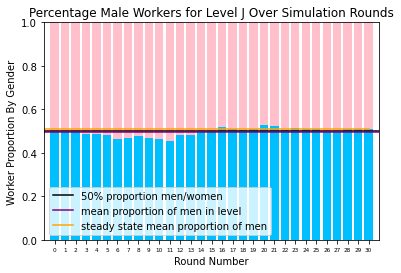

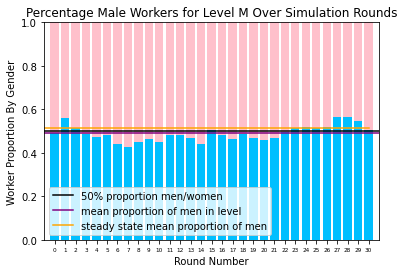

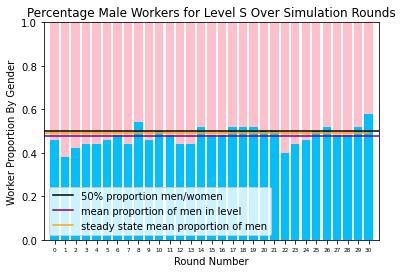

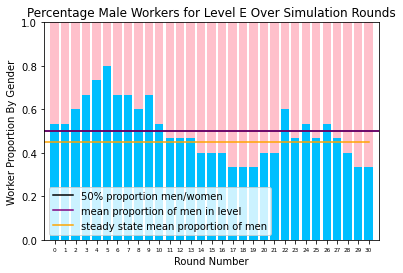

In [15]:
basic_sim = sm.Simulation(sim_type, level_sizes, \
                          sim_types[sim_type][0],sim_types[sim_type][1],sim_types[sim_type][2], \
                          alpha, gamma,\
                           male_productivity, female_productivity, parental_leave,\
                          round_length, num_rounds)

basic_sim.run_simulation(prnt=True)


In [8]:
def create_simulation_data(n, sim_type, parental_leave, round_length, num_rounds):
    stats = np.zeros((7,n))

    for i in range(n):
        
        alpha = 0.281 #np.random.normal(0,1.5)
        gamma = 1 #np.random.uniform(0,25)
        
        sim = sm.Simulation(sim_type, level_sizes, \
                          sim_types[sim_type][0],sim_types[sim_type][1],sim_types[sim_type][2], \
                          alpha, gamma,\
                           male_productivity, female_productivity, parental_leave,\
                          round_length, num_rounds)
        
        stats[0, i] = alpha
        stats[1, i] = gamma
        stats[2, i] = -2.15
        
        sim.run_simulation()
        
        num_men = sim.get_steady_state_gender_dist()[1:]

        for j in range(len(num_men)):
            stats[j+3,i] = num_men[j]
            
        print("Simulation %i finished. %i Percent complete." % (i+1, round(100*(i+1)/n)))
    
    
    
    ts = make_timestamp()
    
    folder_path = os.path.join(path, "%s_%s_data" % (ts, sim_type))
    
    try:   
        folder = os.mkdir(folder_path)
    except:
        raise Exception("Timestamp didn't work for some reason. Please retry")
    
    listing = ts + "_" + sim_type + "_rawdata.csv"
    print(listing)
    
    save_path = os.path.join(folder_path, listing)
                                   
    np.savetxt(save_path, stats, delimiter=",")
    
    #means = np.zeros(4)
    #hws = np.zeros(4)
    
    #rel_stats = stats[2:]
    
    #for i in range(4):
    #    means[i], hws[i] = (rel_stats[i].mean(), rel_stats[i].std())

    #for i in range(1,5):
    #    hws[i-1] = 1.96*hws[i-1]/math.sqrt(n)
    #    print("95 Perc. CI for number of men for level %s: %f +- %f" % (work_levels[i], means[i-1], hws[i-1]))

    #plt.figure()
    #plt.bar([work_levels[i+1] for i in range(4)], means, yerr=hws)
    #plt.show()
    

In [10]:
create_simulation_data(n, sim_type, True, round_length, num_rounds)

AttributeError: 'Simulation' object has no attribute 'base_check_leave'